In [1]:
import numpy as np

# 1 DATASET: MNIST

Fetching the data

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [3]:
print(type(mnist))

<class 'sklearn.utils.Bunch'>


In [4]:
print(mnist['DESCR'])

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

Looking at the data some properties and changing data type as needed

In [5]:
X, y = mnist['data'], mnist['target']

In [6]:
print(X.shape)
print(type(X))

(70000, 784)
<class 'numpy.ndarray'>


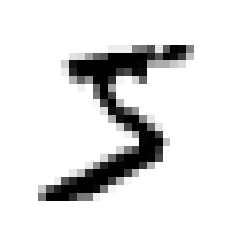

In [7]:
from matplotlib import pyplot as plt

digit_img = X[0].reshape(28,28)

plt.imshow(digit_img, cmap= "binary")
plt.axis("off")
plt.show()

In [8]:
print(y.shape)
print(type(y))

(70000,)
<class 'numpy.ndarray'>


In [9]:
y[0]

'5'

In [10]:
y = y.astype(np.uint8)
print(type(y))

# alternative
# y = np.asarray([int(y_elem) for y_elem in list(y)])

<class 'numpy.ndarray'>


In [11]:
y

array([5, 0, 4, ..., 4, 5, 6], dtype=uint8)

Train-test split

In [12]:
# note X and y are numpy arrays
X_train, y_train, X_test, y_test = X[:60000], y[:60000], X[60000:], y[60000:]

# 2 Binary Classifier

`SGDClassifier` 
- Linear classifiers (SVM, logistic regression, etc.) with SGD training.
-  by default, it fits a linear support vector machine (SVM).


[documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)
> This estimator implements regularized linear models with stochastic gradient descent (SGD) learning: the gradient of the loss is estimated each sample at a time and the model is updated along the way with a decreasing strength schedule (aka learning rate). SGD allows minibatch (online/out-of-core) learning, see the partial_fit method. For best results using the default learning rate schedule, the data should have zero mean and unit variance.

> This implementation works with data represented as dense or sparse arrays of floating point values for the features. The model it fits can be controlled with the loss parameter; by default, it fits a linear support vector machine (SVM).





In [13]:
# change the target labels for binary classification for both train and test sets
# 5 or not 5

y_train_5 = y_train==5
y_test_5 = y_test==5


In [14]:
from sklearn.linear_model import SGDClassifier

# random_state - used for shuffling the data, when shuffle is set to True. 
# Pass an int for reproducible output across multiple function calls. 
sgd_clf = SGDClassifier(random_state=42) 
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [15]:
sgd_clf.predict([X_train[0]]) # predict parameter should be list

array([ True])

In [16]:
y_train_5[0]

True

# 3 Performance Measures

## 1 Accuracy with Cross Validation

In [17]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

under the hood, this is how `cross_val_score` works similarly

In [18]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5): # splits  to train and valid
  clone_clf = clone(sgd_clf)
  
  # train
  X_train_folds = X_train[train_index]
  y_train_folds = y_train_5[train_index]

  # valid
  X_test_folds = X_train[test_index]
  y_test_folds = y_train_5[test_index]

  clone_clf.fit(X_train_folds, y_train_folds)

  y_pred = clone_clf.predict(X_test_folds)
  n_correct = sum(y_pred==y_test_folds)
  print(n_correct/len(y_test_folds))


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.95035
0.96035
0.9604


But our data is skewed, only 10% are '5' and a classifier Not 5 might do better

In [19]:
sum(y_train_5)/len(y_train_5) *100

9.035

## 2 Confusion Matrix

**Requirements:**
1. Actual Predictions 
2. Ground Truth Labels

In [20]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [21]:
y_train_pred.shape

(60000,)

In [22]:
y_train_pred[:5]

array([ True, False, False, False, False])

Computing the Confusion Matrix

In [23]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

Resulting Confusion Matrix <br>
[ true negatives,  false positives] <br>
[ false negatives, true positives]

## 3 Precision and Recall

### Computing Precision and Recall

In [24]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_pred)) # ground truth, prediction
# When it claims an image represents a 5, it is correct only 72.9% of the time

0.8370879772350012


In [25]:
print(recall_score(y_train_5, y_train_pred))
# it only detects 75.6% of the 5s

0.6511713705958311


In [26]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

### Precision/Recall Trade-off

#### Exposing the Trade-off

First, we need to understand how SGDClassifier makes its decision

remember:
```
sgd_clf = SGDClassifier()
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict(X_train)
```

KEY QUESTION: <br>
How does `SGDClassifier()` makes its classification decision?

1. For each instance, it computes a score based on a `decision function`
2. Deciding:
   * If that score is greater than a threshold, it assigns the instance to the positive class
   * Otherwise, it assigns the instance to the negative class

**Example instance:**

In [27]:
y_score = sgd_clf.decision_function([X_train[0]])
y_score

array([2164.22030239])

In [28]:
y_train_5[0] # ground truth

True

In [29]:
threshold = 0
y_pred = (y_score > threshold)
y_pred

array([ True])

In [30]:
# increasing the threshold, increases the false negative -> decreases recall
threshold = 8000
y_pred = (y_score > threshold)
y_pred

array([False])

**Note:**

The threshold is a matter of `.predict()` and not of the computation of precision, recall or f1. 

**So our revised workflow, along with using the whole training set, will be:**


In [31]:
# threshold is 0
sgd_clf = SGDClassifier()
sgd_clf.fit(X_train, y_train_5)

y_train_pred_all = []

# replaces predict
for i in range(len(X_train)):
  y_score = sgd_clf.decision_function([X_train[i]])
  threshold = 0
  y_train_pred = ( y_score > threshold )
  y_train_pred_all.append(y_train_pred)

y_train_pred_all = np.asarray(y_train_pred_all)

print(precision_score(y_train_5, y_train_pred_all))
print(recall_score(y_train_5, y_train_pred_all))
print(f1_score(y_train_5, y_train_pred_all))

0.5450846005568645
0.9389411547684929
0.6897486279558236


In [33]:
# threshold = 8000
sgd_clf = SGDClassifier()
sgd_clf.fit(X_train, y_train_5)

y_train_pred_all = []

# replaces predict
for i in range(len(X_train)):
  y_score = sgd_clf.decision_function([X_train[i]])
  threshold = 800
  y_train_pred = ( y_score > threshold )
  y_train_pred_all.append(y_train_pred)

y_train_pred_all = np.asarray(y_train_pred_all)

print(precision_score(y_train_5, y_train_pred_all))
print(recall_score(y_train_5, y_train_pred_all))
print(f1_score(y_train_5, y_train_pred_all))

0.9145998465865508
0.6598413576830843
0.7666095156450922


**Insights:**
* We can see broadly the trade off: 
   * increasing the threshold,
   * increases the precision
   * decreases the recall

(vice versa)

#### Deciding which threshold to use


1. Plotting precision and recall as function of the threshold

- Requirements: precisions, recalls, thresholds

In [34]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [35]:
y_scores.shape

(60000,)

We use `precision_recall_curve` to get the three required values for the plot


`precision_recall_curve` <br>
- Compute precision-recall pairs for different probability thresholds

- Note: this implementation is restricted to the binary classification task.

[more on the documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html)

In [ ]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [ ]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown                                            # Not shown
plt.show()

2. Precision vs Recall

In [ ]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([0.4368, 0.4368], [0., 0.9], "r:")
plt.plot([0.0, 0.4368], [0.9, 0.9], "r:")
plt.plot([0.4368], [0.9], "ro")
plt.show()

Using these plots to decide which

In [ ]:
# want a 90% precision
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)] #
~7816

In [ ]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
y_train_pred_90

checking

In [ ]:
precision_score(y_train_5, y_train_pred_90)

In [ ]:
recall_score(y_train_5, y_train_pred_90)

### ROC Curve

A high precision classifier may not be very useful when the recall is too low

#### 1. Using SGDClassifier

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [ ]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown                        # Not shown
plt.show()

Computing AUC

In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

#### 2. Using RandomForestClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [ ]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
y_scores_forest

In [ ]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:")
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")
plt.plot([4.837e-3], [0.4368], "ro")
plt.plot([4.837e-3, 4.837e-3], [0., 0.9487], "r:")
plt.plot([4.837e-3], [0.9487], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()